# WOA Data
To compare with SOSE and ECCOv4r3 products

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.2.76:38511")
client

Client Scheduler: tcp://10.32.2.76:38511 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import xarray as xr

In [3]:
ds_salt = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/salt')
ds_temp = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/temp')
ds = xr.merge([ds_salt, ds_temp])
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

In [29]:
#WG boundaries (65˚W, 30˚E; 80˚S, 55˚S)
lower_lat = -79.5
upper_lat = -54.5
left_lon = -64.5
right_lon = 30.5

In [30]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat))
lon_range = dict(lon=slice(left_lon, right_lon))

In [13]:
sst = ds.toa.sel(lev=0, **lon_range, **lat_range)
sst

<xarray.DataArray 'toa' (time: 1, lat: 36, lon: 96)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-0.36122 , -0.566401, ...,  0.408446, -0.033413],
        [ 0.039904,  0.202498, ...,  0.253098, -0.480864]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lev      float64 0.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -57.5 -56.5 -55.5 -54.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Attributes:
    long_name:  statistical mean minus analyzed sea water temperature [degc]

In [14]:
surf_mask = sst.isnull()

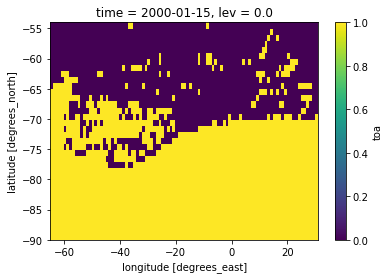

In [15]:
surf_mask.plot()

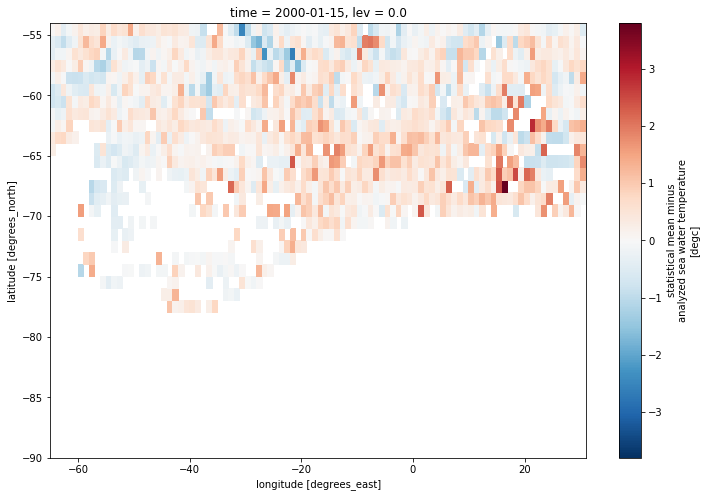

In [16]:
sst.plot(figsize=(12,8))

In [19]:
temp = ds.tan.sel(**lon_range, **lat_range)

In [20]:
temp_deep = temp.sel(lev = slice(2.00e+03, 5.5e+03))

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Interior temperature (2km-5.5km)')

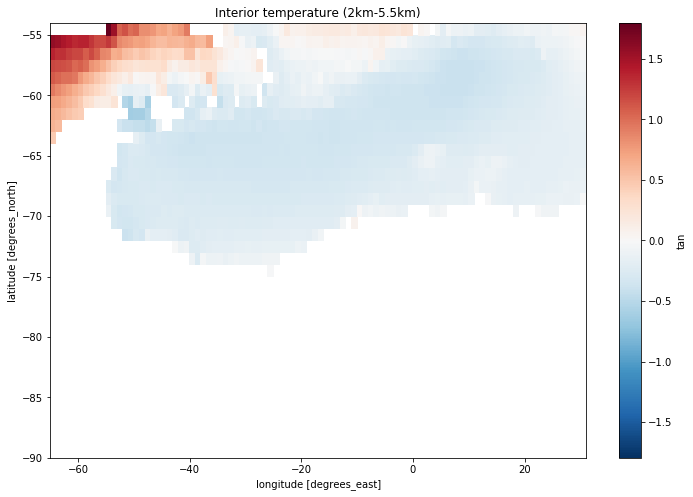

In [21]:
temp_deep.mean('lev').plot(figsize=(12,8))
plt.title('Interior temperature (2km-5.5km)')

**TO DO**
1. We care about the bottom temperature. Look at Ryan's code to see how he figured out how to find bottom temperatures
2. We care about the T/S distribution
    a) Plot T/S distribution from every model and WOA data to compare

In [22]:
tan = ds.tan.load()

In [30]:
tan.lev[-1]

<xarray.DataArray 'lev' ()>
array(5500.)
Coordinates:
    lev      float64 5.5e+03
Attributes:
    grads_dim:      z
    grads_mapping:  levels
    units:          millibar
    long_name:      altitude
    minimum:        0.0
    maximum:        5500.0
    resolution:     54.455444

In [31]:
# this gives us the depth of the bottom cell
lev_max = ds.lev.where(ds.tan.notnull()).max(dim='lev')
# which we can use as an indexer
tan_bottom = tan.sel(lev=lev_max.fillna(0.))

In [32]:
lev_max

<xarray.DataArray 'lev' (time: 1, lat: 180, lon: 360)>
array([[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [3800., 3800., 3800., ..., 3800., 3800., 3800.],
        [3800., 3800., 3900., ..., 3800., 3800., 3800.],
        [4100., 4100., 4100., ..., 4200., 4200., 4100.]]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [33]:
tan_bottom_wg = tan_bottom.sel(**lat_range, **lon_range)

In [34]:
tan_bottom_wg

<xarray.DataArray 'tan' (time: 1, lat: 26, lon: 96)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 1.0221    ,  0.91108996,  0.89701   , ..., -0.2982    ,
         -0.24021   , -0.24031   ],
        [ 1.0046101 ,  1.00241   ,  0.87698996, ..., -0.31581002,
         -0.31541002, -0.31531   ],
        [ 7.0426    ,  6.2198    ,  4.60599   , ..., -0.21141   ,
         -0.24581   , -0.24581   ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lev      (time, lat, lon) float64 0.0 0.0 0.0 ... 5.1e+03 5.5e+03 5.5e+03
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -57.5 -56.5 -55.5 -54.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Attributes:
    long_name:  objectively analyzed mean sea water temperature [degc]

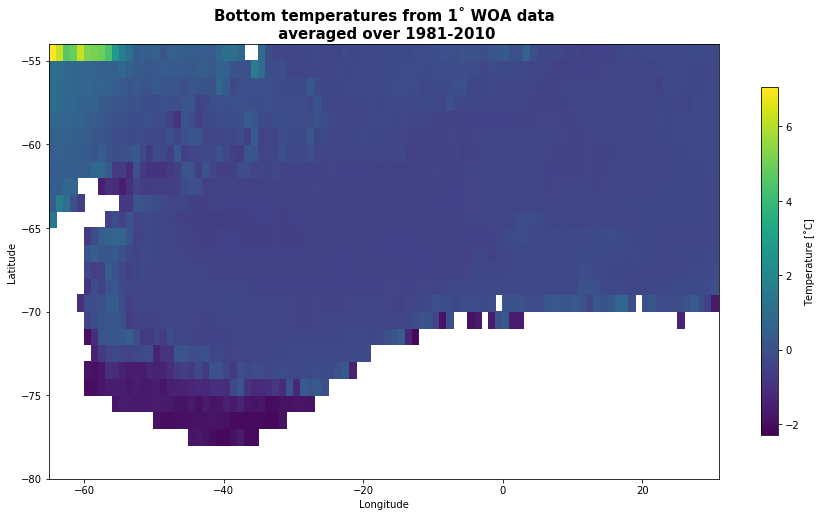

In [85]:
tan_bottom_wg.plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'}, vmin=-2.3, vmax=7.05)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from 1˚ WOA data\n averaged over 1981-2010', fontsize=15, weight='bold');

In [36]:
san = ds.san.load()

In [37]:
# this gives us the depth of the bottom cell
lev_max_slt = ds.lev.where(ds.san.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom = san.sel(lev=lev_max_slt.fillna(0.))

In [38]:
san_bottom_wg = san_bottom.sel(**lat_range, **lon_range)

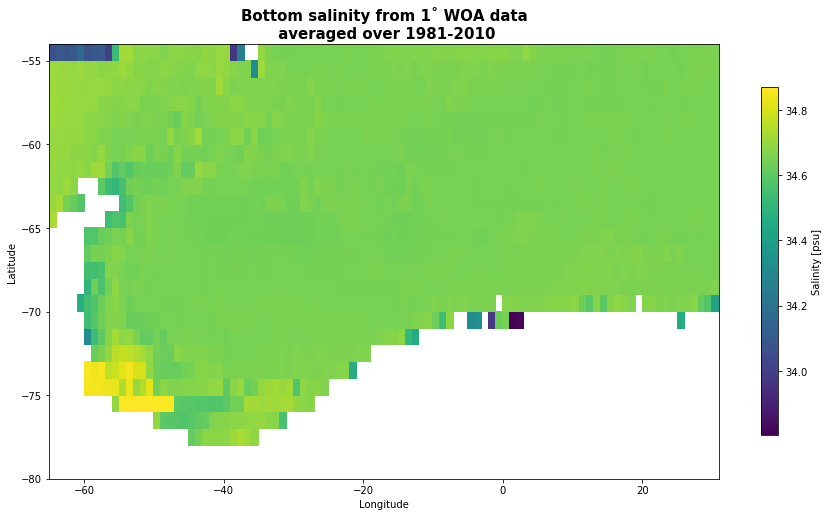

In [39]:
san_bottom_wg.plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from 1˚ WOA data\n averaged over 1981-2010', fontsize=15, weight='bold');

# 2005 - 2017 period

In [40]:
ds_salt_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/salt')
ds_temp_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/temp')
ds_0517 = xr.merge([ds_salt_0517, ds_temp_0517])
ds_0517

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

In [41]:
tan_0517 = ds_0517.tan.load()

In [42]:
# this gives us the depth of the bottom cell
lev_max_0517 = ds_0517.lev.where(ds_0517.tan.notnull()).max(dim='lev')
# which we can use as an indexer
tan_bottom_0517 = tan_0517.sel(lev=lev_max_0517.fillna(0.))

In [43]:
tan_bottom_wg_0517 = tan_bottom_0517.sel(**lat_range, **lon_range)

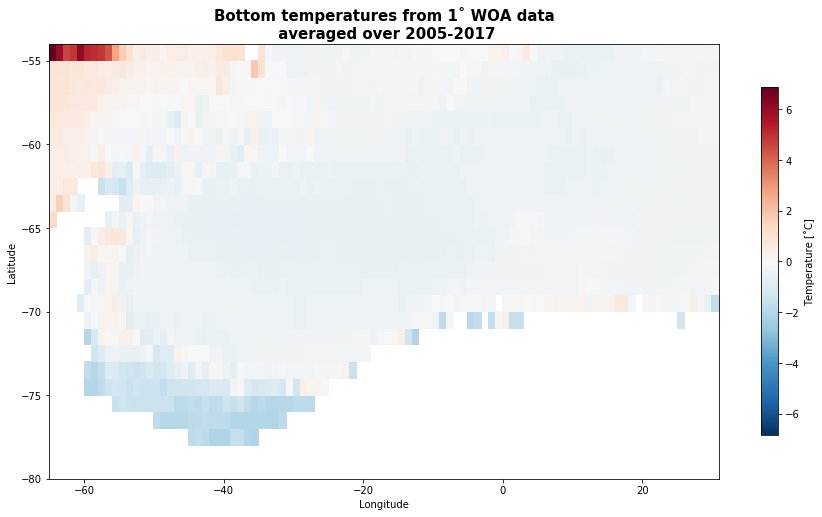

In [50]:
tan_bottom_wg_0517.plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Temperature [˚C]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom temperatures from 1˚ WOA data\n averaged over 2005-2017', fontsize=15, weight='bold');

## Salt

In [46]:
san_0517 = ds_0517.san.load()

In [47]:
# this gives us the depth of the bottom cell
lev_max_slt_0517 = ds_0517.lev.where(ds_0517.san.notnull()).max(dim='lev')
# which we can use as an indexer
san_bottom_0517 = san_0517.sel(lev=lev_max_slt_0517.fillna(0.))

In [48]:
san_bottom_wg_0517 = san_bottom_0517.sel(**lat_range, **lon_range)

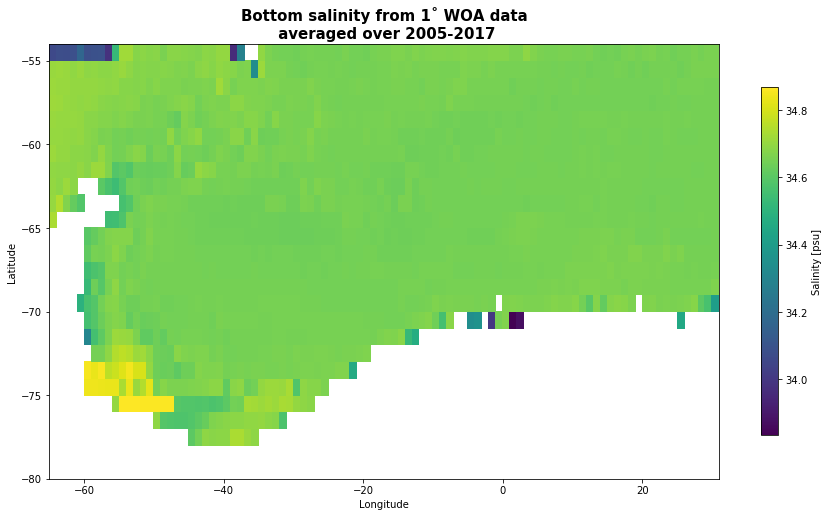

In [49]:
san_bottom_wg_0517.plot(figsize=(15,8), cbar_kwargs={'shrink':0.8, 'label':'Salinity [psu]'})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Bottom salinity from 1˚ WOA data\n averaged over 2005-2017', fontsize=15, weight='bold');